# Quantum Process Tomography

This notebook contains our most important script: Two Qubit Process Tomography.

*Contributors*: Boran Apak, Yorgos Sotiropoulos  and Joost van der Zalm (for the Quantum Information Project [AP3421]) 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import qiskit as qk
import math
from quantuminspire.qiskit import QI
from quantuminspire.credentials import save_account
from qiskit import Aer # for simulating on own pc
save_account('7ff8243ba6d4643e4ec1774b7079f8086df7e872')
QI.set_authentication()
#qi_backend = QI.get_backend('QX single-node simulator') # Possible options: 'QX single-node simulator', 'Spin-2', 'Starmon-5'
qi_backend = Aer.get_backend('qasm_simulator') # for simulating on own pc

## Two Qubit Process Tomography for given states
 Let's see what happens if we try to feed cardinal states before the process

In [3]:
states = [np.array([1,0]),np.array([0,1]),1/np.sqrt(2) * np.array([1,1]), \
          1/np.sqrt(2) * np.array([1,-1]), 1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]
possible_directions = ['I', 'X','Y', 'Z']

pauli_x = np.array([[0,1],[1,0]]) 
pauli_y = np.array([[0,complex(0,-1)],[complex(0,1),0]]) 
pauli_z = np.array([[1,0],[0,-1]])

output_expected_values = np.zeros((36, 16))
input_expected_values = np.zeros((36, 16))

k=0
m=0                      # goes from 0 to 35
for state1 in states:
    l=0
    for state2 in states:
        i=0
        n=0              # goes from 0 to 15
        for direction1 in possible_directions:
            j=0
            
            for direction2 in possible_directions:
                
                if direction1 == 'I' : 
                    input_expected_values[m,n] = 1
                if direction1 == 'X' : 
                    input_expected_values[m,n] = np.real(np.matrix(state1).conjugate() * pauli_x * np.matrix(state1).transpose())
                if direction1 == 'Y' : 
                    input_expected_values[m,n] = np.real(np.matrix(state1).conjugate() * pauli_y * np.matrix(state1).transpose())
                if direction1 == 'Z' : 
                    input_expected_values[m,n] = np.real(np.matrix(state1).conjugate() * pauli_z * np.matrix(state1).transpose())
                    
                if direction2 == 'X' : 
                    input_expected_values[m,n] *= np.real(np.matrix(state2).conjugate() * pauli_x * np.matrix(state2).transpose())
                if direction2 == 'Y' : 
                    input_expected_values[m,n] *= np.real(np.matrix(state2).conjugate() * pauli_y * np.matrix(state2).transpose())
                if direction2 == 'Z' : 
                    input_expected_values[m,n] *= np.real(np.matrix(state2).conjugate() * pauli_z * np.matrix(state2).transpose())
                
                combined_directions = direction1 + direction2
                if combined_directions == 'II' : # For the II case we don't need a circuit
                    output_expected_values[m,n] = 1
                    j += 1
                    n += 1
                    continue  
                #print("Let's find the expectation value for the", direction1, direction2, 'measurements')

                # Define circuit
                q = qk.QuantumRegister(2)
                c = qk.ClassicalRegister(2)
                circuit = qk.QuantumCircuit(q, c)
                
                # Do some initialization for the input states
                circuit.initialize(state1, 0)  # Initialize the 0th qubit using a complex vector
                circuit.initialize(state2, 1)  # Initialize the 1st qubit using a complex vector
                    
                # The gates for the process
                circuit.h(q[0])
                circuit.cx(q[0], q[1])

                # Rotate to make measurements in different bases
                if direction1 == 'X' : 
                    circuit.ry(-math.pi/2, q[0])
                elif direction1 == 'Y' : 
                    circuit.rx(math.pi/2, q[0])
                if direction2 == 'X' : 
                    circuit.ry(-math.pi/2, q[1])
                elif direction2 == 'Y' : circuit.rx(math.pi/2, q[1])

                if direction1 == 'I': 
                    circuit.measure(q[1], c[1]) # The first bit doesn't need to be measured
                elif direction2 == 'I': 
                    circuit.measure(q[0], c[0]) # The second bit doesn't need to be measured
                else : 
                    circuit.measure(q, c)    # Now we want to measure both bits

                #print(circuit)  # To shorten run-time this can be left out

                # Define the experiment
                number_of_shots = 4096
                qi_job = qk.execute(circuit, backend=qi_backend, shots=number_of_shots)
                qi_result = qi_job.result()

                # Look at the results
                histogram = qi_result.get_counts(circuit)
                #print('\nState\tCounts')  # To shorten run-time this can be left out

                # Add the results to the results matrix
                expected_value = 0
                for state, counts in histogram.items() :
                    #print('{0}\t{1}'.format(state, counts))  # To shorten run-time this can be left out
                    expected_value += (-1)**(int(state[0])+int(state[1]))*int(counts)

                expected_value = expected_value / number_of_shots
                output_expected_values[m,n] = expected_value
                #print('For the', direction1, direction2, 'measurements, the expected value=', str(expected_value))
                #print('\n')
                #print('i = ',i,'\nj = ',j,'\nk = ',k,'\nl = ',l,'\nm = ',m,'\nn = ',n)
                #print('--------------------------------------------\n')
                j += 1
                n += 1
            i += 1
        l += 1
        m += 1
    k += 1

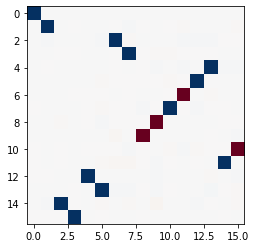

In [4]:
inverse_input_matrix = np.linalg.pinv(np.matrix(input_expected_values.transpose()))
Transfer_matrix = np.matrix(output_expected_values).transpose() * np.matrix(inverse_input_matrix)

plt.imshow(Transfer_matrix, vmin=-1, vmax=1, interpolation='nearest', cmap=cm.RdBu)
plt.show()

In [4]:
a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
a.tofile('data/foo.csv',sep=',',format='%10.5f')

## Making our code more readable
Below we will do exactly the same procedure but now with applying some coding practices such as functions! And recursive calls instead of nested for loops in one code block.

Also while we are at it let's make it so we write code to a file and we can acquire data in batches.

In [24]:
 class QubitProcessTomography:
    def __init__(self, number_of_qubits):
        self.n = number_of_qubits
        self.pauli_transfer_matrix = np.empty((4**number_of_qubits,4**number_of_qubits))
        self.cardinal_states = [np.array([1,0]), np.array([0,1]),\
                                1/np.sqrt(2) * np.array([1,1]), 1/np.sqrt(2) * np.array([1,-1]),\
                                1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]
        self.directions = ['I', 'X','Y', 'Z']
        self.qubits = qk.QuantumRegister(n)
        self.classical_bits = qk.ClassicalRegister(n)
        self.circuit = qk.QuantumCircuit(q, c)
        
    def 
            
q = qk.QuantumRegister(2)
c = qk.ClassicalRegister(2)
circuit = qk.QuantumCircuit(q, c)
    
QPT = QubitProcessTomography(2)       
#pauli_transfer_matrix = np.zeros((4**2,4**2))
print(pauli_transfer_matrix)
print((4**2,4**2))
#print(QPT.pauli_transfer_matrix)

cardinal_states = [np.array([1,0]),np.array([0,1]),1/np.sqrt(2) * np.array([1,1]), \
          1/np.sqrt(2) * np.array([1,-1]), 1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]

        #self.pauli_input_vector = np.zeros((6**n, 16))
        #self.pauli_output_vector =


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(16, 16)


In [26]:
len([1,2,3,4])**2

16

In [ ]:
        index = 0
        for expected_values_string in self.pauli_vector_string:
            pos = 0
            for char in list(expected_values_string):
                if pos == 0:
                    if char == 'I':
                        pauli_input_vector[index, 0] = 1
                    elif char == 'X':
                        pauli_input_vector[index, 0] = np.real(
                            qubit_states[pos].conjugate() * pauli_x * qubit_states[pos].transpose())
                    elif char == 'Y':
                        pauli_input_vector[index, 0] = np.real(
                            qubit_states[pos].conjugate() * pauli_y * qubit_states[pos].transpose())
                    elif char == 'Z':
                        pauli_input_vector[index, 0] = np.real(
                            qubit_states[pos].conjugate() * pauli_z * qubit_states[pos].transpose())
                else:
                    if char == 'X':
                        pauli_input_vector[index, 0] = pauli_input_vector[index, 0] * np.real(
                            qubit_states[pos].conjugate() * pauli_x * qubit_states[pos].transpose())
                    elif char == 'Y':
                        pauli_input_vector[index, 0] = pauli_input_vector[index, 0] * np.real(
                            qubit_states[pos].conjugate() * pauli_y * qubit_states[pos].transpose())
                    elif char == 'Z':
                        pauli_input_vector[index, 0] = pauli_input_vector[index, 0] * np.real(
                            qubit_states[pos].conjugate() * pauli_z * qubit_states[pos].transpose())
                pos += 1
            index += 1

        return pauli_input_vector[:, 0]